<h1><center><strong>CX 4803<br><br>Homework 5</strong></center></h1>
<h3><center><i>Dylan Both</i></center></h3>

In [1]:
# imports
import csv
import numpy as np
import pandas as pd
from scipy import linalg
import seaborn as sns
import matplotlib.pyplot as plt
import random as rand
import math
import scipy.stats
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint

## Problem 1:
We are given the nonlinear model 
\begin{align}
y&=w_{1}x_{1} + w_{1}w_{2}x_{1}x_{2}
\end{align}
with Gaussian noise with estimated variance $\sigma^2=0.1$ and a prior
\begin{align}
p\left(\begin{bmatrix} w_{1}\\w_{2}\end{bmatrix}\right)&\sim N\left(\begin{bmatrix}3\\3\end{bmatrix}, \begin{bmatrix}0.6 & 0\\0 & 1.2\end{bmatrix}\right).
\end{align}
Additionally, we are given the five $(x_1, x_2, y)$ observations:
<ul>
    <li>(0.75, 0.25, 5.3989)</li>
    <li>(0.25, 0.75, 4.6691)</li>
    <li>(0.5, 0,5, 5.4944)</li>
    <li>(1, 0, 3.7503)</li>
    <li>(0, 1, 2.2774)</li>
</ul>

### 1(a):
Below we plot the prior defined above.

In [2]:
# define the prior
mu = 3*np.ones(2) 
Sigma = np.array([[0.6, 0], [0, 1.2]])

Text(0.5, 0.92, 'Prior Distribution')

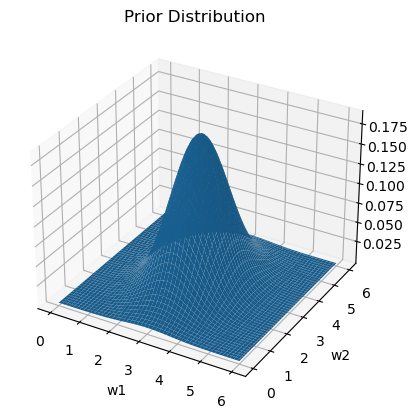

In [3]:
# defining all 3 axis
w2 = np.linspace(0, 6, 100)
w1 = np.linspace(0, 6, 100)
X, Y = np.meshgrid(w1, w2)
pos = np.dstack((X, Y))
prior = multivariate_normal(mu, Sigma)
Z = prior.pdf(pos)
 
# plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z) 
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_title('Prior Distribution')

A multivariate normal distribution is maximized at its mean; therefore, the value of $(w_{1}, w_{2})$ that maximizes the prior is $(3,3)$.

### 1(b):
Our likelihood is defined as follows:
\begin{align}
p(y|w_{1}, w_{2}) &=\sum_{i=1}^{5}N(y_{i}|w_{1}x_{1,i}+w_{1}w_{2}x_{1,i}x_{2,i}, 0.1)\\
&=\frac{1}{(0.2\pi)^{\frac{5}{2}}}\exp{\left(-\frac{1}{0.2}\sum_{i=1}^{5}(w_{1}x_{1, i}+w_{1}w_{2}x_{1,i}x_{2,i}-y_{i})^2\right)}
\end{align}

In [64]:
# define the x1, x2, y values
x1 = np.array([0.75,0.25,0.5,1,0])
x2 = np.array([0.25,0.75,0.5,0,1])
y = np.array([5.3989, 4.6691, 5.4944, 3.7503, 2.2774])

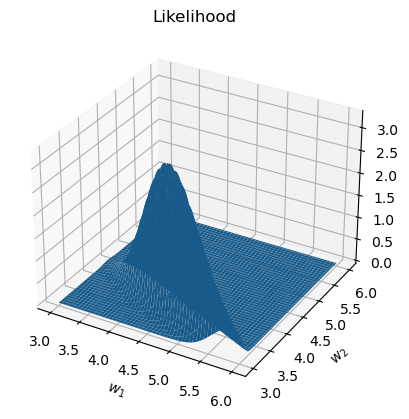

In [65]:
# create a function to get the likelihood of an observation
def likelihood(w1, w2, x1, x2, y):
    sum_squared_diff = np.sum((w1 * x1 + w1 * w2 * x1 * x2 - y)**2)
    return (1 / (0.2 * np.pi)**(5/2)) * np.exp(-sum_squared_diff / 0.2)

# Create a meshgrid of w1 and w2 values
w1_values = np.linspace(3, 6, 100)
w2_values = np.linspace(3, 6, 100)
w1_mesh, w2_mesh = np.meshgrid(w1_values, w2_values)

# Calculate the corresponding function values for the grid
z = np.zeros_like(w1_mesh)
for i in range(len(w1_values)):
    for j in range(len(w2_values)):
        z[i, j] = likelihood(w1_values[i], w2_values[j], x1, x2, y)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(w1_mesh, w2_mesh, z) #, cmap='viridis')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.set_title('Likelihood')

# Show the plot
plt.show()

As seen in the graph above, the likelihood is maximized for approximately the $(w_{1}, w_{2})$ values of $(4.5,4)$.

### 1(c):
We now implement Markov Chain Monte Carlo sampling to sample our posterior distribution. Our posterior is 
\begin{align}
p(w|y)&=\frac{p(y|w)p(w)}{p(y)}.
\end{align}
In the previous two parts, we have calculated our likelihood and prior. Therefore, we know the unnormalized form of our posterior. Taking the ratio of two samples from the unnormalized form of the posterior is equivalent to taking the ratio of two samples from the posterior distribution. Hence, beginning with a random sample from our prior, we iteratively add a random sample from our multivariate normal proposal distribution
\begin{align}
\epsilon&\sim N\left(\begin{bmatrix}0\\ 0\end{bmatrix}, 0.05I\right)
\end{align}
to our current state. We add the new state to our sample of the posterior and set the new state as the current state with probability equal to the ratio of the probability of drawing the new state from the nonnormalized posterior to the probability of drawing the current state from the nonnormalized posterior. However, since each sample is related to the previous sample when we use this technique, we throw away the first 10,000 samples to prevent our samples from being strongly tied to our initial state. Furthermore, we only keep every 1000th sample since nearby samples are highly correlated.


In [99]:
# define the non-normalized posterior
def prob(x):
    return prior.pdf(x) * likelihood(x[0], x[1], x1, x2, y)

# define initial state
state = np.array([3,3])

# initiate sample list
sample = [state]
# loop through each sample
for i in range(100000):
    m =  np.zeros(2)
    Sig = 0.05 * np.eye(2)
    new = state + np.random.multivariate_normal(m, Sig)
    # avoid correlation of samples
    if i > 1000 and i % 100 == 0:
        # check acceptance ratio
        ratio = prob(new) / prob(state)
        r = np.min(np.array([1, ratio]))
        t = np.random.uniform()
        if r >= t:
            sample.append(new)
            state = new
        

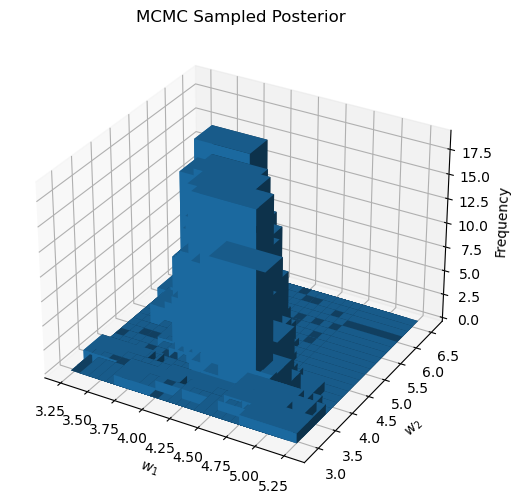

In [101]:
# plot the histogram of our MCMC sample
np.random.seed(0)
data = np.array(sample)

w1 = data[:, 0]
w2 = data[:, 1]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# Creating a 3D histogram
hist, w1edges, w2edges = np.histogram2d(w1, w2, bins = 20)

# Construct arrays for the anchor positions of the bars
w1pos, w2pos = np.meshgrid(w1edges[:-1] + 0.25, w2edges[:-1] + 0.25, indexing="ij")
w1pos = w1pos.ravel()
w2pos = w2pos.ravel()
zpos = 0

# Construct arrays with the dimensions for the bars
dw1 = dw2 = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(w1pos, w2pos, zpos, dw1, dw2, dz, zsort='average')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.set_zlabel('Frequency')

plt.title('MCMC Sampled Posterior')
plt.show()


To confirm our MCMC sample, we plot the pdf of the the product of our prior and likelihood distributions.

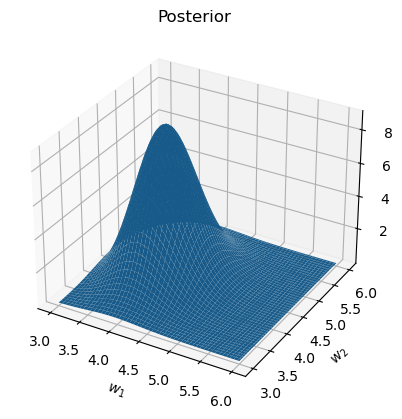

In [10]:
# plot the nonnormalized posterior
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

post = Z.dot(z)
# Plot the surface
ax.plot_surface(w1_mesh, w2_mesh, post)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.set_title('Posterior')

# Show the plot
plt.show()

Since our MCMC plot has the same shape, we can validate the sample of the posterior drawn using MCMC.

### 1(d):
By using MCMC to sample the posterior, we can update our best estimates for $w_1$ and $w_2$ to include information from our y values. From our first plot in part c, we see that the best a posteriori estimates for $(w_{1}, w_{2})$ is $(3.8,4.5)$. These weights are both larger than those obtained in part a; however, the first weight is smaller and the second is larger than those obtained in part b. 

## Problem 2:

### 2(a):
We now implement MCMC with a different proposal distribution. Our new proposal distribution is
\begin{align}
w_{\text{prop}}\sim \frac{1}{s}t_{1}\left(\frac{w_{\text{prop}}-w_{k-1}}{s}\right)
\end{align}
where $t_{1}$ is the pdf of the Cauchy Distribution. Rewriting in terms of $w_{\text{prop}}$
\begin{align}
w_{\text{prop}}&\sim \frac{1}{s^2}t_1w_{\text{prop}}-\frac{1}{s^2}t_1w_{k-1}\\
(1-\frac{1}{s^2}t_1)w_{\text{prop}}&\sim -\frac{1}{s^2}t_1w_{k-1}\\
w_{\text{prop}}&\sim \frac{-\frac{1}{s^2}t_1w_{k-1}}{1-\frac{1}{s^2}t_1}\\
w_{\text{prop}}&\sim \frac{t_1w_{k-1}}{t_1-s^2}
\end{align}
We do this for a number of values of $s$ and plot the rejection rate for each value of $s$.

In [112]:
# define the s values to test
s_vals = np.linspace(0,1,10)
# initiate list to store the acceptance rates for each value of s
acc_list = []
# set the initial state equal to the maximum of the prior
state = np.array([3,3])
# pick the number of samples
n = 1000000

# initiate sample list
sample = [state]
# try each value of s
for s in s_vals:
    # initiate variable to track the number of accepts
    accepted = 0
    total = 0
    # loop through each sample
    for i in range(n):
        t1 = np.random.standard_t(1, 1)
        new = (t1 * state) / (t1-s**2)
        # avoid correlation of samples
        if i > 1000 and i % 100 == 0:
            total = total + 1
            # check acceptance ratio
            ratio = prob(new) / prob(state)
            r = np.min(np.array([1, ratio]))
            t = np.random.uniform()
            if t < r:
                sample.append(new)
                state = new
                accepted = accepted + 1
    acc_rate = round(accepted / total, 2)
    acc_list.append(acc_rate)
        

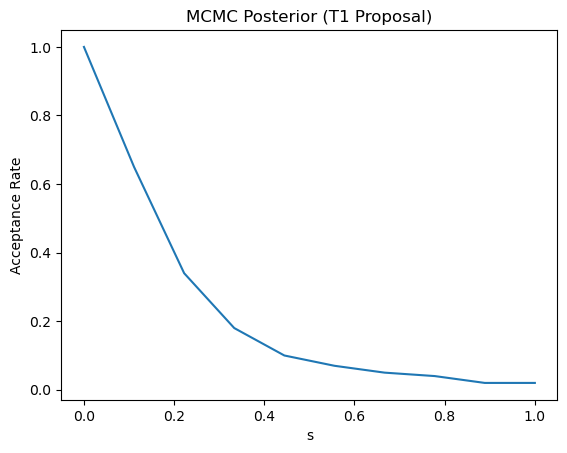

In [113]:
# plot acceptance rate vs s values
plt.plot(s_vals, acc_list)
plt.xlabel('s')
plt.ylabel('Acceptance Rate')
plt.title('MCMC Posterior (T1 Proposal)')
plt.show()

As we increase $s$, the MCMC algorithm gets more picky and accepts fewer samples. Below we plot the estimated posterior distribution obtained above.

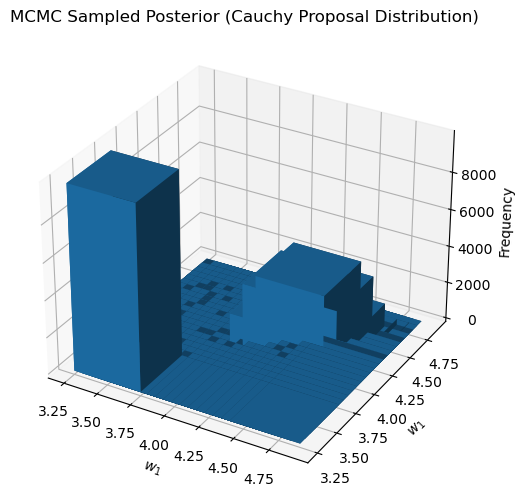

In [114]:
# plot histogram of posterior obtained with this MCMC sampling
data = np.array(sample)

w1 = data[:, 0]
w2 = data[:, 1]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# Creating a 3D histogram
hist, w1edges, w2edges = np.histogram2d(w1, w2, bins = 20)

# Construct arrays for the anchor positions of the bars
w1pos, w2pos = np.meshgrid(w1edges[:-1] + 0.25, w2edges[:-1] + 0.25, indexing="ij")
w1pos = w1pos.ravel()
w2pos = w2pos.ravel()
zpos = 0

# Construct arrays with the dimensions for the bars
dw1 = dw2 = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(w1pos, w2pos, zpos, dw1, dw2, dz, zsort='average')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_1$')
ax.set_zlabel('Frequency')

plt.title('MCMC Sampled Posterior (Cauchy Proposal Distribution)')
plt.show()


### 2(b):
We repeat the above process with the shifted uniform proposal distribution
\begin{align}
w_{\text{prop}}\sim U(w_{k-1}-c, w_{k-1}+c).
\end{align}
This time we plot the acceptance rate vs $c$.

In [117]:
# define the c values to test
c_vals = np.linspace(0,1,10)
# initiate list to store the acceptance rates for each value of c
acc_list = []
# set the initial state equal to the maximum of the prior
state = np.array([3,3])
# pick the number of samples
n = 1000000

# initiate sample list
sample = [state]
# try each value of s
for c in c_vals:
    # initiate variable to track the number of accepts
    accepted = 0
    total = 0
    # loop through each sample
    for i in range(n):
        new = np.random.uniform(state - c, state + c)
        # avoid correlation of samples
        if i > 1000 and i % 100 == 0:
            total = total + 1
            # check acceptance ratio
            ratio = prob(new) / prob(state)
            r = np.min(np.array([1, ratio]))
            t = np.random.uniform()
            if t < r:
                sample.append(new)
                state = new
                accepted = accepted + 1
    acc_rate = round(accepted / total, 2)
    acc_list.append(acc_rate)
        

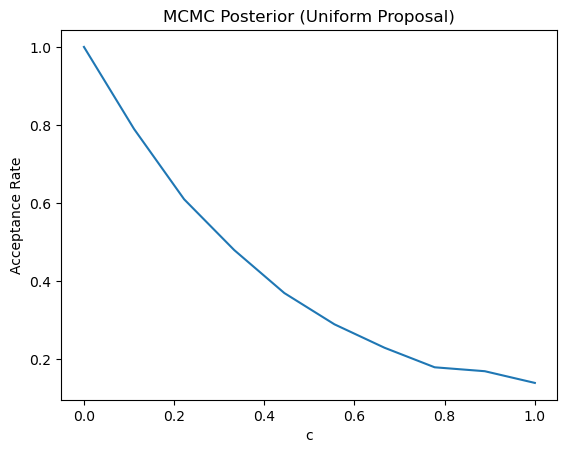

In [118]:
# plot acceptance rate vs c values
plt.plot(c_vals, acc_list)
plt.xlabel('c')
plt.ylabel('Acceptance Rate')
plt.title('MCMC Posterior (Uniform Proposal)')
plt.show()

The magnitude of the shift used for a uniform proposal distribution for MCMC sampling has a similar effect on the acceptance rate that the scaling factor had for our scaled Cauchy proposal distribution. However, increasing c does not decrease the acceptance rate as fast as changes in s did for the Cauchy proposal distribution. The plot below shows the posterior distribution obtained above

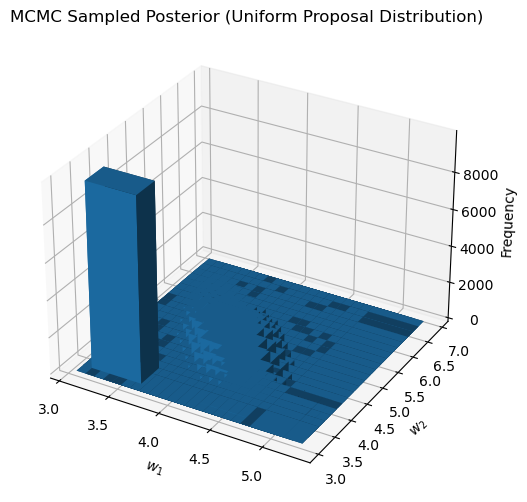

In [120]:
# plot histogram of posterior obtained with this MCMC sampling
data = np.array(sample)

w1 = data[:, 0]
w2 = data[:, 1]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# Creating a 3D histogram
hist, w1edges, w2edges = np.histogram2d(w1, w2, bins = 20)

# Construct arrays for the anchor positions of the bars
w1pos, w2pos = np.meshgrid(w1edges[:-1] + 0.25, w2edges[:-1] + 0.25, indexing="ij")
w1pos = w1pos.ravel()
w2pos = w2pos.ravel()
zpos = 0

# Construct arrays with the dimensions for the bars
dw1 = dw2 = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(w1pos, w2pos, zpos, dw1, dw2, dz, zsort='average')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.set_zlabel('Frequency')

plt.title('MCMC Sampled Posterior (Uniform Proposal Distribution)')
plt.show()


This proposal distribution yields a similar posterior distribution sample to the posterior sample obtained usign the Cauchy distribution. Compared to the posterior sample obtained using the Gaussian proposal distribution, these posterior is concentrated to smaller intervals of $w_1$ and $w_2$ values.

## Problem 3:
Our squared exponential kernel function for Gaussian process regression is 
$$k(x, x^{'})=\exp{\left(-\frac{1}{2s^2}\lVert x-x^{'}\rVert_{2}^{2}\right)}$$
where $x$ is the two-dimensional vector
$$x=\begin{bmatrix}x1\\ x2\end{bmatrix}.$$

### 3(a):
Let $f(x)$ be the true function that the data was generated from and $m(x)$ denote the mean of the observed data. Let $\textbf{x}$ represent the vector of observed $(x_{1}, x_{2})$ data and $\bar{y}$ represent the observed $y$ data. Then
$$f(x)\sim GP(m(x), k(x,x^{'})).$$
This yields a conditional probability 
$$p(\hat{y}|\textbf{y})=N(\hat{y}|\mu_{*}, \Sigma_{*})$$
where 
\begin{align}
\mu_{*}&=m(x)+k(\textbf{x}, x)^{T}k(\textbf{x}, \textbf{x})^{-1}(\bar{y}-m(x))\\
\Sigma_{*} &= k(x,x)-k(\textbf{x},x)^{T}k(\textbf{x}, \textbf{x})^{-1}k(\textbf{x},x)
\end{align}
Our Gaussian Process Regression prediction for a data point $x$ is $\mu_{*}$ for that particular $x$ value.
We assume a mean function to be the constant function $m(x)=0$. Then our prediction becomes 
\begin{align}
\mu_{*}&=k(\textbf{x}, x)^{T}k(\textbf{x}, \textbf{x})^{-1}\bar{y}.
\end{align}
We implement two fold cross validation by splitting our data into sets A and B. We train on set A and test on set B by using set A as the bold $\textbf{x}$ in our above equation and testing for each x value in set B. We do the same for training on set B and testing on set A, then we average the MSE values for both prediction sets to obtain a single MSE value for a single $(s,\sigma^2)$ pair. We repeat this process for a range of  $(s,\sigma^2)$ pairs and report the resulting MSE values in a table.

In [60]:
# read in the data
x1, x2, y = np.loadtxt('hw5_q3.csv', delimiter=',', usecols=(0,1, 2), unpack=True, dtype=float)
x = np.stack((x1, x2), axis=-1)
# split the data into sets A and B
xA, xB = np.split(x, 2)
yA, yB = np.split(y, 2)

In [48]:
# define s and sigma2 values to test
s_list = np.linspace(0.01, 0.25, 10) 
sigma2_list = np.linspace(0.001, 0.1, 5) 
sigma2_list = np.append(sigma2_list, np.linspace(-0.001, -0.1, 5))
sigma2_list = np.append(sigma2_list, np.array([0]))
# initiate a dict to store mse values for each combo of s and sigma2 
mse_dict = {}

# loop through each combo of s and sigma2
for s in s_list:
    mse_dict[s] = {}
    for sigma2 in sigma2_list:
        # get covariance matrices for each split
        n = len(xA)
        KA = np.zeros((n, n))
        KB = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                KA[i, j] = np.exp(-0.5 / (s ** 2) * np.linalg.norm(xA[i] - xA[j]) ** 2)
                KB[i, j] = np.exp(-0.5 / (s ** 2) * np.linalg.norm(xB[i] - xB[j]) ** 2)

        CA = KA + sigma2 * np.eye(n)
        CB = KB + sigma2 * np.eye(n)

        # initiate lists to store mean values and variance values
        # predictions from training on set A
        yyA = []
        # predictions for training on set B
        yyB = []
        for num in range(n):
            # value to test from set A
            xAval = xA[num]
            # value to test from set B
            xBval = xB[num]
            normA = []
            normB = []
            for i in range(n):
                normA.append( np.linalg.norm(xA[i] - xBval) ** 2)
                normB.append( np.linalg.norm(xB[i] - xAval) ** 2)
            normA = np.array(normA)
            normB = np.array(normB)
            # kvce for bold x being set A
            kvecA = np.exp(-0.5 / (s ** 2) * normA)
            # kvec for bold x being set B
            kvecB = np.exp(-0.5 / (s ** 2) * normB)
            # prediction for training on A and testing on B
            yAval = np.dot(kvecA.T, np.linalg.solve(CA, yA))
            # prediction for training on B and testing on A
            yBval = np.dot(kvecB.T, np.linalg.solve(CB, yB))
            yyA.append(yAval)
            yyB.append(yBval)
        # Convert the lists to NumPy arrays
        yyA = np.array(yyA)
        yyB = np.array(yyB)

        # calculate MSE for each train test split
        mseA = np.sum(np.square(yyA - yB))
        mseB = np.sum(np.square(yyB - yA))
        # take the average of these values
        mse = 0.5 * (mseA + mseB)
        mse_dict[s][sigma2] = mse


The following table shows the MSE for each $s, \sigma^2$ combination. For any given $s$ value, the MSE increases as we increase $\sigma^2$. Conversly, for any given $\sigma^2$ value, the MSE decreases if we increase $s$.

In [53]:
# initiate lists to hold values
s_values = []
sigma2_values = []
mse_values = []

# unpack the dictionary
for s, inner_dict in mse_dict.items():
    for sigma2, mse in inner_dict.items():
        s_values.append('{:.2f}'.format(s))
        sigma2_values.append('{:.4f}'.format(sigma2))
        mse_values.append('{:.8f}'.format(mse))

# Create a table to display the values
df = pd.DataFrame({
    's': s_values,
    'sigma^2': sigma2_values,
    'MSE': mse_values
})

df

,s,sigma^2,MSE
0,0.01,0.0010,28.08897676
1,0.01,0.0258,28.11006528
2,0.01,0.0505,28.13064675
3,0.01,0.0753,28.15056363
4,0.01,0.1000,28.16980899
...,...,...,...
105,0.25,-0.0258,65.15834804
106,0.25,-0.0505,475.77646992
107,0.25,-0.0753,58.13420778
108,0.25,-0.1000,12.18924847


### 3(b):
The pair $(s, \sigma^2)$ that minimizes test MSE is $(0.25, 0.0258)$. We use these values to train the model on all of the data.

In [54]:
df[df.MSE.astype(float) == min(df.MSE.astype(float))]

,s,sigma^2,MSE
100,0.25,0.0258,2.18709594


In [55]:
s = 0.25
sigma2 = 0.0258
n = len(x)
K = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        K[i, j] = np.exp(-0.5 / (s ** 2) * np.linalg.norm(x[i] - x[j]) ** 2)
                

C = K + sigma2 * np.eye(n)
model = np.linalg.solve(C, y)

### 3(c):
Using the trained model from part b, we make predictions on the $(x_{1}, x_{2})$ pairs
\begin{align}
(0,2)\\
(1.8, 1.8)\\
(2,1)\\
(0.5,0.5)
\end{align}
and report the predictions in a table.

In [56]:
x1 = np.array([0, 1.8, 2, 0.5])
x2 = np.array([2, 1.8, 1, 0.5])

# define a function that makes prediction
def predict(x1, x2):
    xx = np.stack((x1, x2), axis=-1)
    # initiate an empty list to store prediciton values
    yy = []
    # this condition does not affect predictions for this problem. It is for plotting the prediction surface
    if len(xx > 2):
        for xval in xx:
            # calculate the squared two norm
            norm = []
            for i in range(len(x)):
                norm.append(np.linalg.norm(x[i] - xval) ** 2)
            norm = np.array(norm)
            kvec = np.exp(-0.5 / (s ** 2) * norm)
            # make prediction
            yval = np.dot(kvec.T, model)
            yy.append(yval)
    else:
        norm = []
        for i in range(len(x)):
            norm.append(np.linalg.norm(x[i] - xval) ** 2)
        norm = np.array(norm)
        kvec = np.exp(-0.5 / (s ** 2) * norm)
        # make prediction
        yval = np.dot(kvec.T, model)
        yy.append(yval)

    return yy

preds = predict(x1, x2)
preds

[-6.19416428337483e-05,
 -1.9006060431877096e-06,
 0.00011967978315667242,
 -0.9325104600312191]

Let $\hat{y}$ denote the models predictions. The following table displays the models predictions for the given input data.

In [64]:
df = pd.DataFrame({
    '$x_1$': x1,
    '$x_2$': x2,
    '$\\hat{y}$': preds
})
df.reset_index(drop=True, inplace=True)
pprint(df)

   $x_1$  $x_2$  $\hat{y}$
0    0.0    2.0  -0.000062
1    1.8    1.8  -0.000002
2    2.0    1.0   0.000120
3    0.5    0.5  -0.932510


### 3(d):
Constraining $x_1$ and $x_2$ to the interval $[0,2]$ we plot the prediction surface and the standard deviaton surface seperately.

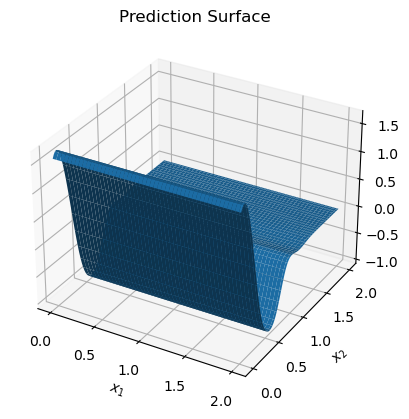

In [65]:
# plot the prediction surface
x1_values = np.linspace(0, 2, 100)
x2_values = np.linspace(0, 2, 100)
x1_mesh, x2_mesh = np.meshgrid(x1_values, x2_values)

# Calculate the corresponding function values for the grid
z = np.zeros_like(x1_mesh)
for i in range(len(x1_values)):
    for j in range(len(x2_values)):
        z[i, j] = predict(np.array(x1_values[i]), np.array(x2_values[j]))[0]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x1_mesh, x2_mesh, z) #, cmap='viridis')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Prediction Surface')

# Show the plot
plt.show()

The prediction surface looks like a polynomial function of $x_2$ with inflection points around the $x_2$ values of $0, 0.5,$ and $1$.

In [66]:
# write a function to return the standard deviation
def standard_deviation(x1, x2):
    xx = np.stack((x1, x2), axis=-1)
    # initiate an empty list to store prediciton values
    vari = []
    # calculate the squared two norm
    for xval in xx:
        # calculate the squared two norm
        norm = []
        for i in range(len(x)):
            norm.append(np.linalg.norm(x[i] - xval) ** 2)
        norm = np.array(norm)
        kvec = np.exp(-0.5 / (s ** 2) * norm)
        # get variance
        vari.append(sigma2 + 1 - np.dot(kvec, model))
    return np.sqrt(vari)

C:\Users\dylan\AppData\Local\Temp\ipykernel_3388\451593919.py:16: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(vari)


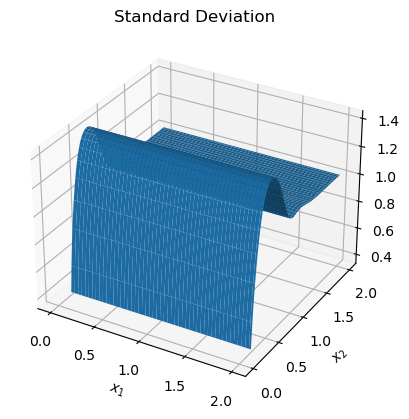

In [67]:
# Calculate the corresponding function values for the grid
z = np.zeros_like(x1_mesh)
for i in range(len(x1_values)):
    for j in range(len(x2_values)):
        z[i, j] = standard_deviation(np.array(x1_values[i]), np.array(x2_values[j]))[0]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x1_mesh, x2_mesh, z) #, cmap='viridis')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Standard Deviation')

# Show the plot
plt.show()

The standard deviation is almost like an inversion of the prediction surface. Standard deviation is high for $x_2$ values around $0.5$. Relating this visual to the prediction surfcae visual, we see that standard deviation is high when the predicted value is small and low when the predicted value is large.